In [160]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d.axes3d import get_test_data
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pymongo
from pymongo import MongoClient
import datetime
import warnings
import itertools
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

In [161]:
pip install pymongo

Note: you may need to restart the kernel to use updated packages.


In [162]:
timeSeriesData = pd.DataFrame(columns=['symbol','date','cur_price','trade_quantity','updown_rate'])
timeSeriesCountData = pd.DataFrame(columns=['symbol','date','count'])

In [163]:

client = MongoClient('mongodb://127.0.0.1:27017/')
db = client['mph']
collection_price = db['crypto_prices']
collection_agg = db['token_aggs']

In [171]:
price_data = collection_price.find({'symbol':'BNB'})
agg_data = collection_agg.find({'symbol':'BNB'})
#data = collection.find()
print(agg_data)
index = 0

In [172]:
for price_detail in price_data:
    timeSeriesData.loc[index, 'symbol'] = price_detail['symbol']
    timeSeriesData.loc[index,'date']= price_detail['date']
    timeSeriesData.loc[index, 'cur_price'] = price_detail['cur_price']
    timeSeriesData.loc[index, 'trade_quantity'] = price_detail['trade_quantity']
    timeSeriesData.loc[index, 'updown_rate'] = price_detail['updown_rate']
    index+=1

index1 = 0

for agg_detail in agg_data:
    timeSeriesCountData.loc[index1, 'symbol'] = agg_detail['symbol']
    timeSeriesCountData.loc[index1,'date']= datetime.datetime.strptime(str(agg_detail['date']),'%Y%m%d')
    timeSeriesCountData.loc[index1, 'count'] = agg_detail['count']/18 # nomarlization
    index1+=1


timeSeriesData = timeSeriesData.sort_values(['date'])
timeSeriesCountData = timeSeriesCountData.sort_values(['date'])

In [173]:
print(timeSeriesData)
print(timeSeriesCountData)

    symbol                 date cur_price trade_quantity updown_rate
702    BNB  2018-01-01 00:00:00      8.45         642510       -0.94
701    BNB  2018-01-02 00:00:00      8.72        1230000         3.2
700    BNB  2018-01-03 00:00:00       9.3         926410        6.65
699    BNB  2018-01-04 00:00:00      9.14         918410       -1.72
698    BNB  2018-01-05 00:00:00     14.88        2600000        62.8
..     ...                  ...       ...            ...         ...
4      BNB  2019-11-30 00:00:00    15.677        4950000       -2.89
3      BNB  2019-12-01 00:00:00   15.5309        4120000       -0.93
2      BNB  2019-12-02 00:00:00   15.2112        3980000       -2.06
1      BNB  2019-12-03 00:00:00   15.3207        4820000        0.72
0      BNB  2019-12-04 00:00:00   15.2864        5360000       -0.22

[703 rows x 5 columns]
    symbol                 date      count
1      BNB  2017-08-21 00:00:00  0.0555556
0      BNB  2017-08-22 00:00:00  0.0555556
6      BNB  2017-08

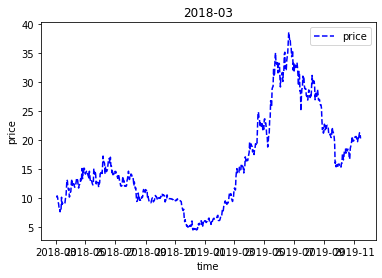

In [174]:
startDate1 = "2018-03-02"
endDate1 = "2019-11-15"

startDate = datetime.datetime.strptime(startDate1,"%Y-%m-%d")
endDate = datetime.datetime.strptime(endDate1,"%Y-%m-%d")

monthDate = startDate +pd.DateOffset(months=3)
###########################################################
# train을 위한 시계열 범위를 19년 4월 부터 6월 31일까지 1개 분기로 정함
###########################################################
timeSeriesData1 = timeSeriesData.loc[(timeSeriesData['date'] >= startDate) & (timeSeriesData['date'] <= endDate), :]
timeSeriesCountData1 = timeSeriesCountData.loc[(timeSeriesCountData['date'] >= startDate) & (timeSeriesCountData['date'] <= monthDate), :]

plt.plot(timeSeriesData1['date'].values, timeSeriesData1['cur_price'].values,'b--')
#plt.plot(timeSeriesCountData1['date'].values, timeSeriesCountData1['count'].values, 'ro')
plt.title(startDate.strftime('%Y-%m'))
plt.xlabel('time')
plt.ylabel('price')
plt.legend(['price','lift','downhill'])
plt.show()

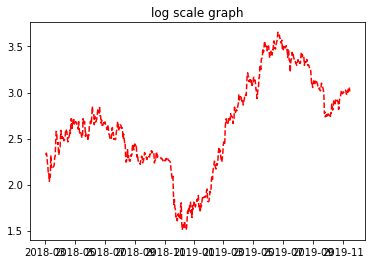

In [175]:
timeSeriesData1['log_price'] = np.log(np.array(timeSeriesData1['cur_price'],dtype=np.float32))

plt.plot(timeSeriesData1['date'].values, timeSeriesData1['log_price'].values, 'r--')
plt.title('log scale graph')
plt.show()

<Figure size 432x288 with 0 Axes>

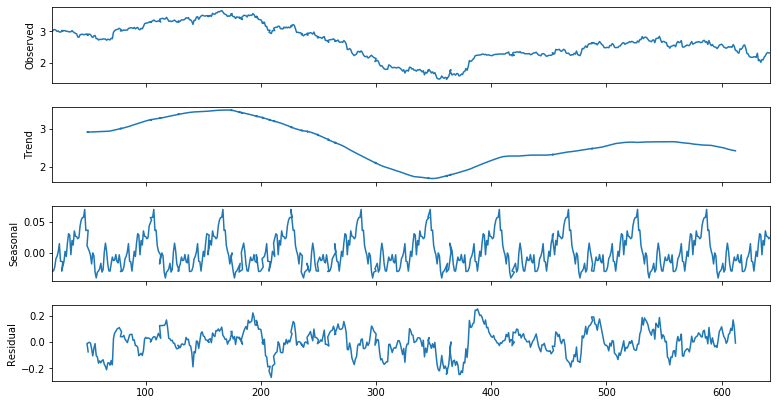

In [176]:
decompostion = seasonal_decompose(timeSeriesData1.log_price,freq=60)
fig = plt.figure()
fig = decompostion.plot()
fig.set_size_inches(12,6)

In [177]:
# 0 과 2 사이에서  p, d, q를 선언  
p = d= q = range(0,2)

In [178]:
# 가능한 모든 다른 조합을 만들어 냄 
pdq = list(itertools.product(p,d,q))

In [179]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [180]:
seasonal_pdq = [(x[0],x[1],x[2],60) for x in list(itertools.product(p,d,q))]

In [181]:
seasonal_pdq

[(0, 0, 0, 60),
 (0, 0, 1, 60),
 (0, 1, 0, 60),
 (0, 1, 1, 60),
 (1, 0, 0, 60),
 (1, 0, 1, 60),
 (1, 1, 0, 60),
 (1, 1, 1, 60)]

In [182]:
warnings.filterwarnings("ignore")

In [183]:
for param in pdq :
    for param_seasonal in seasonal_pdq :
        try :
            mod = sm.tsa.statespace.SARIMAX(timeSeriesData1.log_price,
                                           order = param ,
                                           trend = 't',
                                           seasonal_order = param_seasonal,
                                           enforce_stationarity=False,
                                           enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA {} x {} - AIC:{}'.format(param,param_seasonal,results.aic))
        except : 
            print('exception')
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 60) - AIC:1959.771252138381
ARIMA (0, 0, 0) x (0, 0, 1, 60) - AIC:1233.336118534951
ARIMA (0, 0, 0) x (0, 1, 0, 60) - AIC:726.5465664646982
ARIMA (0, 0, 0) x (0, 1, 1, 60) - AIC:658.5324882734683
ARIMA (0, 0, 0) x (1, 0, 0, 60) - AIC:702.2388589437355
ARIMA (0, 0, 0) x (1, 0, 1, 60) - AIC:675.8487374041379
ARIMA (0, 0, 0) x (1, 1, 0, 60) - AIC:661.9721590570466
ARIMA (0, 0, 0) x (1, 1, 1, 60) - AIC:646.8521903149202
ARIMA (0, 0, 1) x (0, 0, 0, 60) - AIC:1126.479344182635
ARIMA (0, 0, 1) x (0, 0, 1, 60) - AIC:511.0882936383748
ARIMA (0, 0, 1) x (0, 1, 0, 60) - AIC:67.00106961179226
ARIMA (0, 0, 1) x (0, 1, 1, 60) - AIC:68.6508758660582
ARIMA (0, 0, 1) x (1, 0, 0, 60) - AIC:38.76242392703041
ARIMA (0, 0, 1) x (1, 0, 1, 60) - AIC:19.589533420291566
ARIMA (0, 0, 1) x (1, 1, 0, 60) - AIC:78.08468157976935
ARIMA (0, 0, 1) x (1, 1, 1, 60) - AIC:64.48330735611032
ARIMA (0, 1, 0) x (0, 0, 0, 60) - AIC:-1960.4476841946794
ARIMA (0, 1, 0) x (0, 0, 1, 60) - AIC:-1816.56

In [188]:
mod = sm.tsa.statespace.SARIMAX(timeSeriesData1.log_price,
                               order=(0,0,1),
                               seasonal_order=(1,1,1,60),
                               trend='t',
                               enforce_stationarity=False,
                               enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          log_price   No. Observations:                  624
Model:             SARIMAX(0, 0, 1)x(1, 1, 1, 60)   Log Likelihood                 -27.242
Date:                            Thu, 19 Dec 2019   AIC                             64.483
Time:                                    21:48:58   BIC                             85.576
Sample:                                         0   HQIC                            72.759
                                            - 624                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift        8.68e-05   7.92e-05      1.096      0.273   -6.84e-05       0.000
ma.L1          0.9050      0.018   

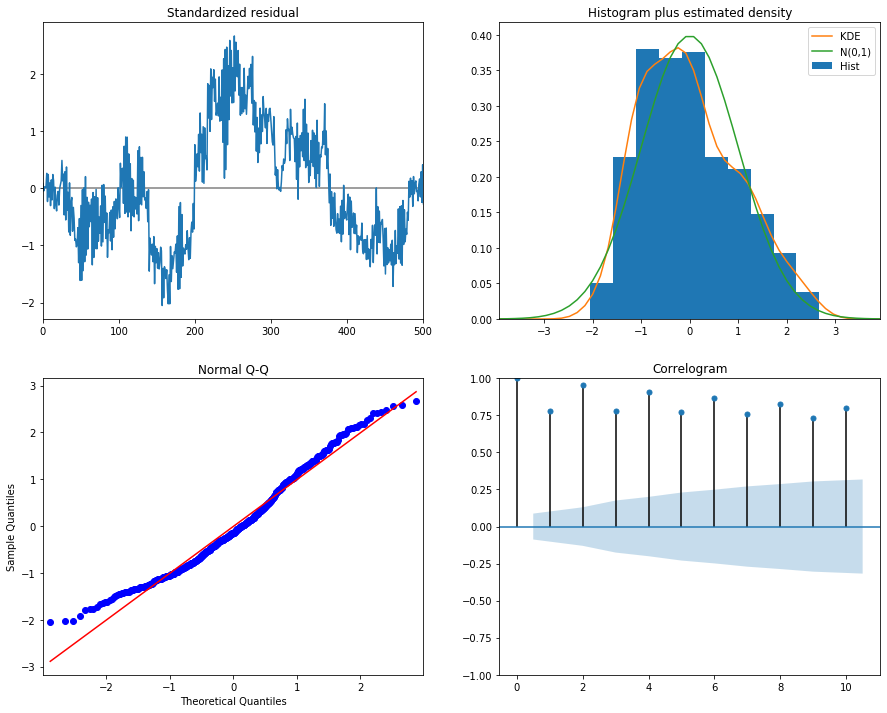

In [189]:
results.plot_diagnostics(figsize=(15,12))
plt.show()

In [192]:
timeSeriesData1['forecast'] = results.predict(start=503, end=643,dynamic = True)-1

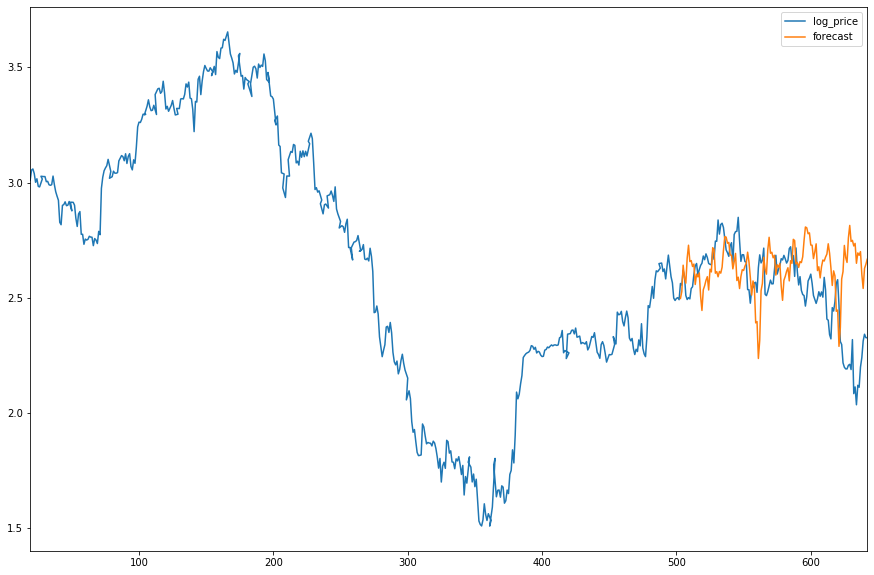

In [193]:
timeSeriesData1[['log_price','forecast']].plot(figsize=(15,10))